# "PyTorch Broadcasting"
> Running computations on tensors of different ranks with PyTorch

- toc: true
- badges: true
- comments: false
- categories: [jupyter, fastai, pytorch, broadcasting]
- image: images/chart-preview.png

In [77]:
#hide
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [78]:
#hide
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [79]:
#hide
threes_train = (path/'train'/'3').ls().sorted()
sevens_train = (path/'train'/'7').ls().sorted()
threes_valid = (path/'valid'/'3').ls().sorted()
sevens_valid = (path/'valid'/'7').ls().sorted()

threes_train

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

# Introduction

Recently, I stumbled upon [fastai](https://github.com/fastai/fastai), a deep learning library with a very eye catching slogan: *Making neural nets uncool again*.
As it turns out, there is also a very [good course](https://course.fast.ai/) on this library from one of its creators, Jeremy Howard, that is very much hands on.

The task of Lesson 3 is to build a Digit Classifier from hand written images based on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).
But before training any models, Jeremy explains that one should always create a simplistic baseline to later put the performance of the fancy machine learning models into perspective.
The baseline should be easy to implement, e.g., by only relying on simple arithmetic operations.
The key idea of the lessons' baseline is to average the pixel values for each digit (in our small example below only we only use the digits 3 and 7) and then compute the difference between a given digit image to these average.

During the last few years, I did a lot of typical data scientist tasks as part of my PhD.
One thing that I always found quite fascinating is how NumPy treats arrays with different dimensions/ranks during arithmetic operations through a mechanism called **broadcasting**.
PyTorch tensors also support this mechanism and I really liked how Jeremy used it for creating the baseline.
In addition, I think that Jeremys explained very well how broadcasting works so I decided to summarize it in this blog post.


# Training and Validation Data

We have four datasets with digit images available: A training and a validation dataset of threes, and a training and a validation dataset of fours.
For example, the second three from the training dataset looks like so:

<AxesSubplot:>

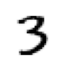

In [80]:
#collapse-hide
show_image(Image.open(threes_train[1]))

The first thing we want to do is to load the training images into tensors.

In [81]:
three_train_tensors = [tensor(Image.open(o)) for o in threes_train]
seven_train_tensors = [tensor(Image.open(o)) for o in sevens_train]
# lets see how many tensors we have
len(three_train_tensors), len(seven_train_tensors)

(6131, 6265)

Each tensor contains a pixel matrix, the values in the matrix describe the color of each pixel on a grey scale.
A 0 indicates a white pixel and a 255 indicates a black pixel.
For example, row and column 4 to 10 from the pixel matrix of the three above looks like so.

In [82]:
three_train_tensors[1][4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Now, for calculating the mean of all pixel values, i.e., the *ideal* three or seven, we need to stack the image matrices.
In other words, we need to create a cube.
Since we will later on calculate the mean of each pixel based on the cube, we will end up with float values.
Therefore, we already convert integers to floats and transform them to be between 0 and 1. 

In [83]:
threes_train_stacked = torch.stack(three_train_tensors).float()/255
sevens_train_stacked = torch.stack(seven_train_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

The results are two cube, i.e., two rank-3 tensors, with the above shapes.
The rank of each tensor is the number of axes while the shape is this size of each axis.

# A Metric to Determine the Similarity

With the rank-3 tensors we can now calculate the mean three digit and the mean seven digit.
We need both to compare how similar a given digit is to the *ideal* three or seven.

(<AxesSubplot:>, <AxesSubplot:>)

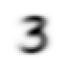

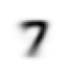

In [84]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

show_image(mean3), show_image(mean7)

For comparing how similar a given digit is to each of these means, a good metric is the L1 norm, i.e., the *mean absolute value of differences*.
This might sound complicated, but it is actually very easy to understand how the L1 norm is calculated just by looking at some code.

In [85]:
# let's load the second image again
i_3 = threes_train_stacked[1]

# then calculate the list of absolute differences for three and sevens
list_of_differences_3 = (i_3 - mean3).abs()
list_of_differences_7 = (i_3 - mean7).abs()

# then calculate the l1 norm which is the mean of all of these differences
l1_3 = list_of_differences_3.mean()
l1_7 = list_of_differences_7.mean()

l1_3, l1_7

(tensor(0.1114), tensor(0.1586))

The L1 norm, i.e., the mean absolute value of differences, is smaller for the mean three so it is a three.
This is correct, great!

# Computing the Metric with Broadcasting

We now come to the most intersting part of this blog post: We will use broadcasting to calculate the L1 norm for both validation datasets.
First, we again create two rank-3 tensors from the validation data.

In [86]:
# read in validation data (same approach as above)
threes_valid_stacked = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
sevens_valid_stacked = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255

threes_valid_stacked.shape,sevens_valid_stacked.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Then we define a function that computes the L1 norm with a similar approach as above.

In [87]:
def l1_norm(a,b): return (a-b).abs().mean((-1,-2))

l1_norm(i_3, mean3)

tensor(0.1114)

This seems to work! But did you notice the (-1,-2) in the mean function?
With these parameters, we instruct the function to only use the last two axes for calculating the mean.
Since we have a list of rank-2 tensors, we could have also ommited the parameters.
But let's see what happens if we supply the complete stack of valid threes, i.e., a rank-3 tensor, instead of a single three, i.e., a rank-2 tensor.


In [88]:
result = l1_norm(threes_valid_stacked, mean3)
result, result.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

Wow! The same function now returns a rank-1 tensor instead of a single value.
And this rank-1 tensor comprises the L1 norm for each three of the validation dataset.
But why can we substract a rank-2 tensor (the b in the l1_norm function) form a rank_3 tensor (the a in the l1_norm function)?

Jeremy explains it like so:

*The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting. That is, it will automatically expand the tensor [actually PyTorch only pretends to expand the tensor, it does not allocate any extra memory] with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write. After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result.*

This is also why we supplied (-1,-2) to the mean function. Since we always want the mean of the last two axes, no matter what rank the provided tensors have.

# Testing the Accuracy of the Baseline Model

For testing the accuracy of the baseline model, we need a simple function that computes whether the l1_norm of a given image is smaller for the mean three or mean seven.

In [89]:
def is_3(x): return l1_norm(x, mean3) < l1_norm(x, mean7)

is_3(i_3)

tensor(True)

We again can use broadcasting to run this function on the validation dataset!

In [90]:
is_3(threes_valid_stacked)

tensor([True, True, True,  ..., True, True, True])

With all the pieces together, we can calculate how many digit images have been correctly identified as threes or sevens, i.e., the accuracy of our baseline model.

In [91]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
average_accuracy = (accuracy_3s+accuracy_7s)/2

average_accuracy

tensor(0.9511)

The average accuracy is well above 90%. It will be interesting to see whether we can top this with deep learning 😉.

# Closing Remarks

In this blog post, I used Jeremys approach for creating a baseline Digit Classifier model to provide a broadcasting example.
By why should one use broadcasting instead of, for example, just creating some loops?
I give you two reasons:
1. A lot less code that is also much easier to read (even though the concepts are a lot more complex).
2. PyTorch calculations are run in C (or CUDA if using a GPU), which makes it thousands of times faster than pure Python (or up to millions of times faster on a GPU).